In [1]:
#Load USPS Dataset
import h5py
path="usps.h5"
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = hf.get('test')
        X_test = test.get('data')[:]
        y_test = test.get('target')[:]

#Load Libraries
from sklearn.model_selection import train_test_split
import numpy as np
import math 
import matplotlib.pyplot as plt 
import time
from sklearn.svm import SVC
%matplotlib inline

In [2]:
#Concatenate training and test set
X=np.row_stack((X_train,X_test))
y=np.append(y_train,y_test)
#Split into and initial training set size and the rest of the data
X_train_p, X_other, y_train_p, y_other = train_test_split(X, y, random_state=0,test_size=0.85)
print("Training Proper Size:", len(X_train_p))
print("Other Data Samples:",len(X_other))


Training Proper Size: 1394
Other Data Samples: 7904


# Online SVM Inductive Add To Calibration Set (Mode 1)

In [36]:
p_values=np.zeros((len(X_other),len(set(y_train_p))))
online_X_train=X_train_p.copy()
online_y_train=y_train_p.copy()
online_X_cal=[]
online_y_cal=[]
score_cal=[]

In [37]:
SVM=SVC()
SVM.fit(online_X_train,online_y_train)
for i in range(len(X_other)):
    d_func=SVM.decision_function([X_other[i]])
    if len(online_X_cal)==0:
        #For the first sample set p-values to 1 for every label
        p_values[i]=np.ones(len(set(y_train_p)))
        online_X_cal=X_other[i].reshape(1,len(X_other[0]))
        online_y_cal=y_other[i]
    else:
        for j in range(len(set(y_train_p))):
            score_extend=np.append(score_cal,(-1*d_func[0][j]))
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(score_extend>=score_extend[-1])
            #tau=np.random.uniform()
            #p_values[i][j]=(np.sum(score_extend>score_extend[-1])+(tau*(np.sum(score_extend==score_extend[-1]))))/len(score_extend)
        online_X_cal=np.row_stack((online_X_cal,X_other[i]))
        online_y_cal=np.append(online_y_cal,y_other[i])
    score_cal.append(-1*d_func[0][y_other[i]])

In [23]:
#Use the p-values to get cumulative totals of errors, multiple and empty prediction sets
sig=0.20
error=0
multiple=0
empty=0
err_array=np.zeros(len(X_other))
mult_array=np.zeros(len(X_other))
empt_array=np.zeros(len(X_other))
prediction_set=[0] * len(X_other)
for i in range(len(X_other)):
    prediction_set[i]=list(np.where(p_values[i]>(sig))[0])
    if y_other[i] not in prediction_set[i]:
        error+=1
    if len(prediction_set[i]) > 1:
        multiple+=1
    if len(prediction_set[i]) ==0:
        empty+=1
    err_array[i]=error
    mult_array[i]=multiple
    empt_array[i]=empty


Text(0.5, 1.0, 'SVM Inductive - Mode 1 - Significance Level= 20%')

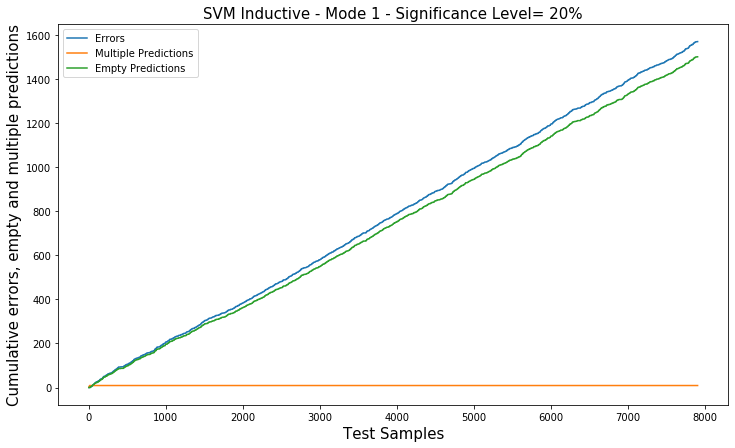

In [24]:
plt.figure(figsize=(12,7))
plt.plot(range(len(X_other)),err_array)
plt.plot(range(len(X_other)),mult_array)
plt.plot(range(len(X_other)),empt_array)
plt.xlabel("Test Samples",fontsize=15)
plt.ylabel("Cumulative errors, empty and multiple predictions",fontsize=15)
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("SVM Inductive - Mode 1 - Significance Level= 20%",fontsize=15)

# Validity Curve

In [38]:
error_rate=[]
sigs=[0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for sig in sigs:
    prediction_set=[0] * len(X_other)
    error=0
    for i in range(len(X_other)):
        prediction_set[i]=list(np.where(p_values[i]>(sig))[0])
        if y_other[i] not in prediction_set[i]:
            error+=1
    error_rate=np.append(error_rate,error/len(X_other))


Text(0.5, 1.0, 'Inductive Online SVM Mode 1 Validity Curve')

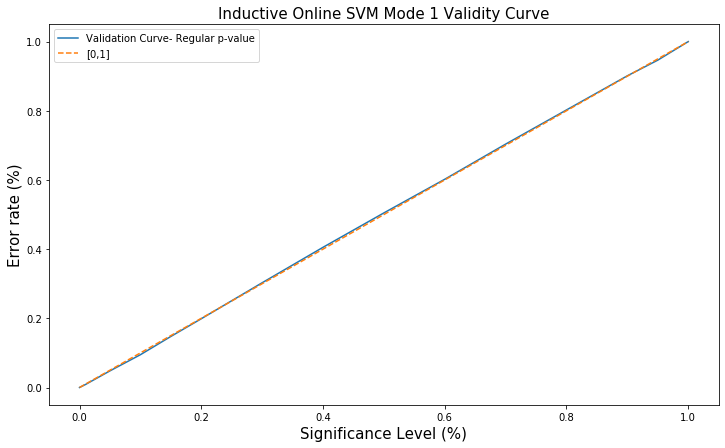

In [39]:
plt.figure(figsize=(12,7))
plt.plot(sigs,error_rate)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validation Curve- Regular p-value","[0,1]"])
plt.xlabel("Significance Level (%)",fontsize=15)
plt.ylabel("Error rate (%)",fontsize=15)
plt.title("Inductive Online SVM Mode 1 Validity Curve",fontsize=15)

# Online SVM Inductive Update Training Set Every 1000 Samples (Mode 2)

In [20]:
p_values=np.zeros((len(X_other),len(set(y_train_p))))
online_X_train=X_train_p.copy()
online_y_train=y_train_p.copy()
online_X_cal=[]
online_y_cal=[]
score_cal=[]
SVM=SVC()
SVM.fit(online_X_train,online_y_train)
for i in range(len(X_other)):
    d_func=SVM.decision_function([X_other[i]])
    if len(online_X_cal)==0:
        #For the first sample set p-values to 1 for every label
        p_values[i]=np.ones(len(set(y_train_p)))
        online_X_cal=X_other[i].reshape(1,len(X_other[0]))
        online_y_cal=y_other[i]
    else:
        for j in range(len(set(y_train_p))):
            score_extend=np.append(score_cal,(-1*d_func[0][j]))
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(score_extend>=score_extend[-1])
            #tau=np.random.uniform()
            #p_values[i][j]=(np.sum(score_extend>score_extend[-1])+(tau*(np.sum(score_extend==score_extend[-1]))))/len(score_extend)
        online_X_cal=np.row_stack((online_X_cal,X_other[i]))
        online_y_cal=np.append(online_y_cal,y_other[i])
    score_cal=np.append(score_cal,-1*d_func[0][y_other[i]])
    
    if len(online_X_cal) > 1000:
        #If the size of the calibration set is greater than 1000, add all samples to the training set
        online_X_train=np.row_stack((online_X_train,online_X_cal))
        online_y_train=np.append(online_y_train,online_y_cal)
        online_X_cal=[]
        online_y_cal=[]
        score_cal=[]
        #Re-fit the SVM on new training set
        SVM.fit(online_X_train,online_y_train)

In [42]:
#Use the p-values to get cumulative totals of errors, multiple and empty prediction sets
sig=0.05
error=0
multiple=0
empty=0
err_array=np.zeros(len(X_other))
mult_array=np.zeros(len(X_other))
empt_array=np.zeros(len(X_other))
prediction_set=[0] * len(X_other)
for i in range(len(X_other)):
    prediction_set[i]=list(np.where(p_values[i]>(sig))[0])
    if y_other[i] not in prediction_set[i]:
        error+=1
    if len(prediction_set[i]) > 1:
        multiple+=1
    if len(prediction_set[i]) ==0:
        empty+=1
    err_array[i]=error
    mult_array[i]=multiple
    empt_array[i]=empty


Text(0.5, 1.0, 'SVM Inductive - Mode 2 - Significance Level= 1%')

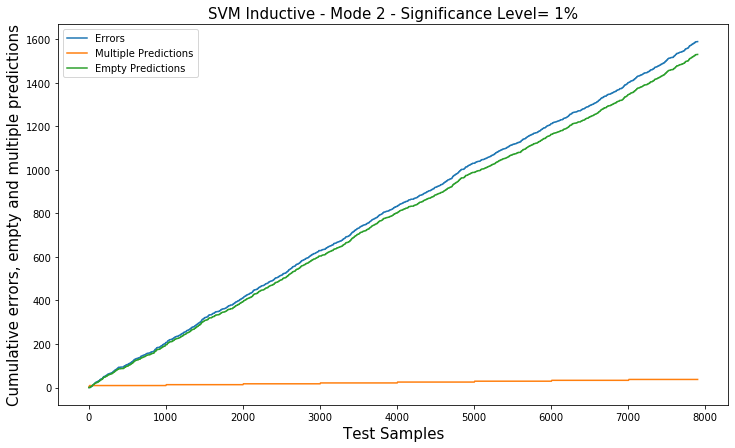

In [33]:
plt.figure(figsize=(12,7))
plt.plot(range(len(X_other)),err_array)
plt.plot(range(len(X_other)),mult_array)
plt.plot(range(len(X_other)),empt_array)
plt.xlabel("Test Samples",fontsize=15)
plt.ylabel("Cumulative errors, empty and multiple predictions",fontsize=15)
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("SVM Inductive - Mode 2 - Significance Level= 1%",fontsize=15)

# Validity Curve

In [25]:
error_rate=[]
sigs=[0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for sig in sigs:
    prediction_set=[0] * len(X_other)
    error=0
    for i in range(len(X_other)):
        prediction_set[i]=list(np.where(p_values[i]>(sig))[0])
        if y_other[i] not in prediction_set[i]:
            error+=1
    error_rate=np.append(error_rate,error/len(X_other))

Text(0.5, 1.0, 'Inductive Online SVM Mode 2 Validity Curve')

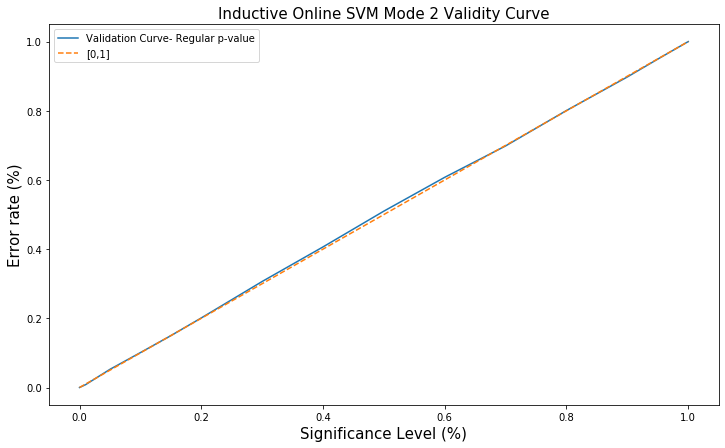

In [35]:
plt.figure(figsize=(12,7))
plt.plot(sigs,error_rate)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validation Curve- Regular p-value","[0,1]"])
plt.xlabel("Significance Level (%)",fontsize=15)
plt.ylabel("Error rate (%)",fontsize=15)
plt.title("Inductive Online SVM Mode 2 Validity Curve",fontsize=15)

# Online SVM Inductive Update Training Set but retain some samples in Calibration Set (Mode 3)

In [41]:
p_values=np.zeros((len(X_other),len(set(y_train_p))))
online_X_train=X_train_p.copy()
online_y_train=y_train_p.copy()
online_X_cal=[]
online_y_cal=[]
score_cal=[]
SVM=SVC()
SVM.fit(online_X_train,online_y_train)
for i in range(len(X_other)):
    d_func=SVM.decision_function([X_other[i]])
    if len(online_X_cal)==0:
        p_values[i]=np.ones(len(set(y_train_p)))
        online_X_cal=X_other[i].reshape(1,len(X_other[0]))
        online_y_cal=y_other[i]
    else:
        for j in range(len(set(y_train_p))):
            score_extend=np.append(score_cal,(-1*d_func[0][j]))
            #Calculate p-values of test sample
            p_values[i][j]=np.mean(score_extend>=score_extend[-1])
            #tau=np.random.uniform()
            #p_values[i][j]=(np.sum(score_extend>score_extend[-1])+(tau*(np.sum(score_extend==score_extend[-1]))))/len(score_extend)
        online_X_cal=np.row_stack((online_X_cal,X_other[i]))
        online_y_cal=np.append(online_y_cal,y_other[i])
    score_cal=np.append(score_cal,-1*d_func[0][y_other[i]])
    
    if len(online_X_cal) > 1000:
        #If calibration set size is greater than 1000, tranfer 800 samples to training set and leave 200 in calibration set
        online_X_train=np.row_stack((online_X_train,online_X_cal[:len(online_X_cal)-200]))
        online_y_train=np.append(online_y_train,online_y_cal[:len(online_y_cal)-200])
        online_X_cal=online_X_cal[len(online_X_cal)-200:]
        online_y_cal=online_y_cal[len(online_y_cal)-200:]
        #Re-fit SVM to new training set
        SVM.fit(online_X_train,online_y_train)
        #Re-calculate calibration set scores
        d_func_cal=SVM.decision_function(online_X_cal)
        row=np.arange(0,len(d_func_cal))
        score_cal=-1*d_func_cal[row,online_y_cal]

In [47]:
#Use the p-values to get cumulative totals of errors, multiple and empty prediction sets
sig=0.05
error=0
multiple=0
empty=0
err_array=np.zeros(len(X_other))
mult_array=np.zeros(len(X_other))
empt_array=np.zeros(len(X_other))
prediction_set=[0] * len(X_other)
for i in range(len(X_other)):
    prediction_set[i]=list(np.where(p_values[i]>(sig))[0])
    if y_other[i] not in prediction_set[i]:
        error+=1
    if len(prediction_set[i]) > 1:
        multiple+=1
    if len(prediction_set[i]) ==0:
        empty+=1
    err_array[i]=error
    mult_array[i]=multiple
    empt_array[i]=empty


Text(0.5, 1.0, 'SVM Inductive - Mode 3 - Significance Level= 20%')

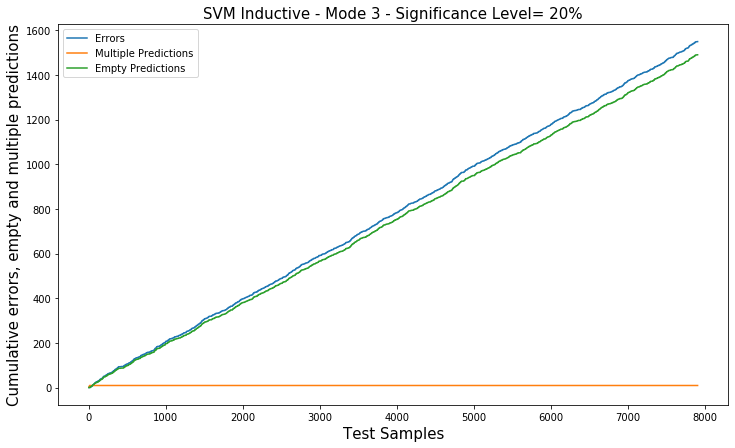

In [85]:
plt.figure(figsize=(12,7))
plt.plot(range(len(X_other)),err_array)
plt.plot(range(len(X_other)),mult_array)
plt.plot(range(len(X_other)),empt_array)
plt.xlabel("Test Samples",fontsize=15)
plt.ylabel("Cumulative errors, empty and multiple predictions",fontsize=15)
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("SVM Inductive - Mode 3 - Significance Level= 20%",fontsize=15)

# Validity Curve

In [44]:
error_rate=[]
sigs=[0,0.01,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for sig in sigs:
    prediction_set=[0] * len(X_other)
    error=0
    for i in range(len(X_other)):
        prediction_set[i]=list(np.where(p_values[i]>(sig))[0])
        if y_other[i] not in prediction_set[i]:
            error+=1
    error_rate=np.append(error_rate,error/len(X_other))

Text(0.5, 1.0, 'Inductive Online SVM Mode 3 Validity Curve')

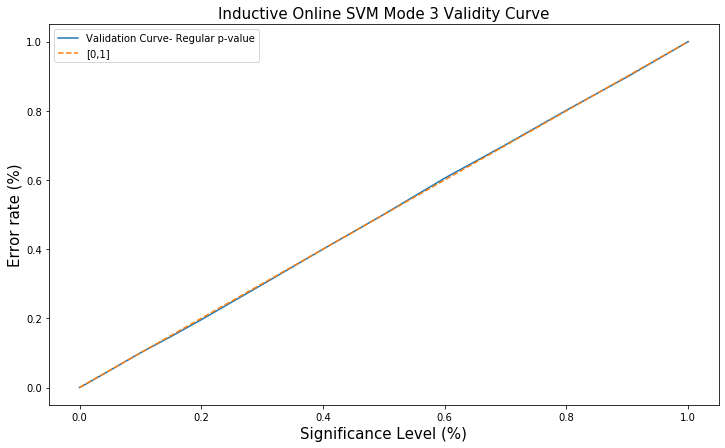

In [46]:
plt.figure(figsize=(12,7))
plt.plot(sigs,error_rate)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validation Curve- Regular p-value","[0,1]"])
plt.xlabel("Significance Level (%)",fontsize=15)
plt.ylabel("Error rate (%)",fontsize=15)
plt.title("Inductive Online SVM Mode 3 Validity Curve",fontsize=15)